#### 1. Пример реализации градиентного бустинга вручную

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor  # Используем для построения деревьев

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.full_like(X, value, dtype=float) - создать массив такой же формы, как X заполненный значением value (КОПИРУЕТ массив X, можем поменять тип, но принудительно)  
np.full(shape, value, dtype=float) - то же что и full_like(), но без копирования... тут просто указываем форму (вектор - можно одним числом) и тип

In [2]:
np.full(10, 1, float)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Алгоритм бустинга:
#### 1. Посчитали базовое предсказание
#### 2. Вычли из y сигмоиду предсказания - это остатки
#### 3. Обучились на таргет == остаткам (там дерево регрессии)
#### 4. Сложили предыдущее предсказание с предиктом текущего дерева, получив новое предсказание
#### 5. ... вычли из y сигмоиду обновленного предсказания - это снова остатки... и по новой

In [3]:
class GradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None
    
    #Встроенный декоратор - в данном случае ничего полезного не добавляет функции
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        
        # Инициализация начального предсказания (логиты)
        
        self.initial_prediction = np.log(np.mean(y) / (1 - np.mean(y)))         # посчитали одно число - базовое предсказание
        predictions = np.full_like(y, self.initial_prediction, dtype=float)     # сделали вектор длинны y этого базового предсказания БАЗОВЫЙ ПРЕДИКТ

        for _ in range(self.n_estimators):
            # Вычисляем градиент (производная log loss)
            residuals = y - self.sigmoid(predictions)                           # 1. Считаем сигмоиду для базовых (обновленных) предсказаний и вычитаем это из реальных значений

            # Обучаем дерево на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)                                              # 2. Обучаем дерево предсказывать остатки

            # Обновляем предсказания
            predictions += self.learning_rate * tree.predict(X)                 # 3. К базовому предсказанию прибавляем  (learning_rate * predict дерева)   (обновляем предикт)

            # Сохраняем дерево
            self.trees.append(tree)                                             # тут как бы сохраняем возможность докидывать предсказания по дереву

    def predict_proba(self, X):
        predictions = np.full(X.shape[0], self.initial_prediction, dtype=float)
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        return self.sigmoid(predictions)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)                                 # True False превращаем в int

In [4]:
# здесь используется декоратор staticmethod, который позволяет использовать функцию sigmoid без привязки к классу, внутри которого находится функция,
#       т.к. сама функция не зависит от состояния экземпляра

# Функция через экземпляр

gb = GradientBoostingClassifier()
print(gb.sigmoid(10))

# Функция вызывается через класс напрямю

print(GradientBoostingClassifier.sigmoid(10))

0.9999546021312976
0.9999546021312976


In [5]:
# Генерация синтетического датасета
X, y = make_classification(n_samples=100, n_features=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# y_train

In [7]:
np.mean(y_train) / (1 - np.mean(y_train))

0.951219512195122

In [8]:
np.log(np.mean(y_train) / (1 - np.mean(y_train)))

-0.050010420574661305

In [9]:
base_predict = np.full_like(y_train, np.log(np.mean(y_train) / (1 - np.mean(y_train))), dtype=float); # base_predict для трейна

In [10]:
# Вектор ошибок в логитах после вычитания базового предикта из реальных классов

# y_train - GradientBoostingClassifier.sigmoid(np.full_like(y_train, base_predict, dtype=float))

In [11]:
tree = DecisionTreeRegressor(max_depth=3) 

# y_train - sigmoid(базового предикта) - учим первое дерево на ошибках

tree.fit(X_train, y_train - GradientBoostingClassifier.sigmoid(np.full_like(y_train, base_predict, dtype=float)))

DecisionTreeRegressor(max_depth=3)

In [12]:
# после первого эстиматора имеем предикт  как сигмоиду от (суммы базового предикта с предиктом первого дерева * learning_rate)

predict_1 = GradientBoostingClassifier.sigmoid(base_predict + tree.predict(X_train) * 0.1) ; predict_1

array([0.50030989, 0.47532994, 0.47532994, 0.47532994, 0.49031111,
       0.50030989, 0.50030989, 0.50030989, 0.47532994, 0.50030989,
       0.47532994, 0.47532994, 0.50030989, 0.50030989, 0.50030989,
       0.50030989, 0.47532994, 0.50030989, 0.50030989, 0.50030989,
       0.50030989, 0.47532994, 0.47532994, 0.47532994, 0.49031111,
       0.50030989, 0.47532994, 0.47532994, 0.50030989, 0.47532994,
       0.47532994, 0.47532994, 0.47532994, 0.49031111, 0.47532994,
       0.50030989, 0.47532994, 0.50030989, 0.50030989, 0.50030989,
       0.47532994, 0.47532994, 0.50030989, 0.47532994, 0.47532994,
       0.47532994, 0.47532994, 0.47532994, 0.50030989, 0.49031111,
       0.47532994, 0.50030989, 0.47532994, 0.50030989, 0.50030989,
       0.50030989, 0.47532994, 0.47532994, 0.50030989, 0.50030989,
       0.50030989, 0.50030989, 0.47532994, 0.50030989, 0.50030989,
       0.47532994, 0.47532994, 0.47532994, 0.47532994, 0.49031111,
       0.47532994, 0.50030989, 0.47532994, 0.47532994, 0.50030

#### делаем так столько раз, сколько у нас n_estimators

---

In [13]:
# Обучение модели
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gb.fit(X_train, y_train)

In [14]:
# предикт проба 100 деревьев

gb.predict_proba(X_train)

array([0.89770312, 0.10231587, 0.10231587, 0.10231587, 0.3294965 ,
       0.89823171, 0.88183626, 0.89770312, 0.10350774, 0.88183626,
       0.10231587, 0.07364572, 0.89823171, 0.89770312, 0.89823171,
       0.89823171, 0.10231587, 0.89770312, 0.89823171, 0.89770312,
       0.89770312, 0.1129812 , 0.10231587, 0.10231587, 0.60515086,
       0.89770312, 0.10231587, 0.10231587, 0.89823171, 0.10231587,
       0.10231587, 0.10231587, 0.10231587, 0.24955141, 0.1129812 ,
       0.89823171, 0.10014812, 0.89823171, 0.88183626, 0.88123378,
       0.10231587, 0.10231587, 0.88183626, 0.10231587, 0.10231587,
       0.10231587, 0.10231587, 0.10231587, 0.89770312, 0.8896038 ,
       0.10231587, 0.88183626, 0.1129812 , 0.86327229, 0.89770312,
       0.89823171, 0.10231587, 0.10231587, 0.89770312, 0.89770312,
       0.89823171, 0.88183626, 0.10231587, 0.89823171, 0.89823171,
       0.10231587, 0.10231587, 0.10231587, 0.1129812 , 0.86878666,
       0.10231587, 0.89823171, 0.10231587, 0.10231587, 0.89823

In [15]:
# первое из деревьев

tree_1 = gb.trees[0]

In [16]:
# предсказание первого дерева

# это совпадает с predict_1 из ручного примера

gb.sigmoid(np.full_like(y_train, np.log(np.mean(y_train) / (1 - np.mean(y_train))), float) + tree_1.predict(X_train) * 0.1) # == predict_1

array([0.50030989, 0.47532994, 0.47532994, 0.47532994, 0.49031111,
       0.50030989, 0.50030989, 0.50030989, 0.47532994, 0.50030989,
       0.47532994, 0.47532994, 0.50030989, 0.50030989, 0.50030989,
       0.50030989, 0.47532994, 0.50030989, 0.50030989, 0.50030989,
       0.50030989, 0.47532994, 0.47532994, 0.47532994, 0.49031111,
       0.50030989, 0.47532994, 0.47532994, 0.50030989, 0.47532994,
       0.47532994, 0.47532994, 0.47532994, 0.49031111, 0.47532994,
       0.50030989, 0.47532994, 0.50030989, 0.50030989, 0.50030989,
       0.47532994, 0.47532994, 0.50030989, 0.47532994, 0.47532994,
       0.47532994, 0.47532994, 0.47532994, 0.50030989, 0.49031111,
       0.47532994, 0.50030989, 0.47532994, 0.50030989, 0.50030989,
       0.50030989, 0.47532994, 0.47532994, 0.50030989, 0.50030989,
       0.50030989, 0.50030989, 0.47532994, 0.50030989, 0.50030989,
       0.47532994, 0.47532994, 0.47532994, 0.47532994, 0.49031111,
       0.47532994, 0.50030989, 0.47532994, 0.47532994, 0.50030

In [17]:
predict_1

array([0.50030989, 0.47532994, 0.47532994, 0.47532994, 0.49031111,
       0.50030989, 0.50030989, 0.50030989, 0.47532994, 0.50030989,
       0.47532994, 0.47532994, 0.50030989, 0.50030989, 0.50030989,
       0.50030989, 0.47532994, 0.50030989, 0.50030989, 0.50030989,
       0.50030989, 0.47532994, 0.47532994, 0.47532994, 0.49031111,
       0.50030989, 0.47532994, 0.47532994, 0.50030989, 0.47532994,
       0.47532994, 0.47532994, 0.47532994, 0.49031111, 0.47532994,
       0.50030989, 0.47532994, 0.50030989, 0.50030989, 0.50030989,
       0.47532994, 0.47532994, 0.50030989, 0.47532994, 0.47532994,
       0.47532994, 0.47532994, 0.47532994, 0.50030989, 0.49031111,
       0.47532994, 0.50030989, 0.47532994, 0.50030989, 0.50030989,
       0.50030989, 0.47532994, 0.47532994, 0.50030989, 0.50030989,
       0.50030989, 0.50030989, 0.47532994, 0.50030989, 0.50030989,
       0.47532994, 0.47532994, 0.47532994, 0.47532994, 0.49031111,
       0.47532994, 0.50030989, 0.47532994, 0.47532994, 0.50030

---

In [18]:
# Предсказание
y_pred = gb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9


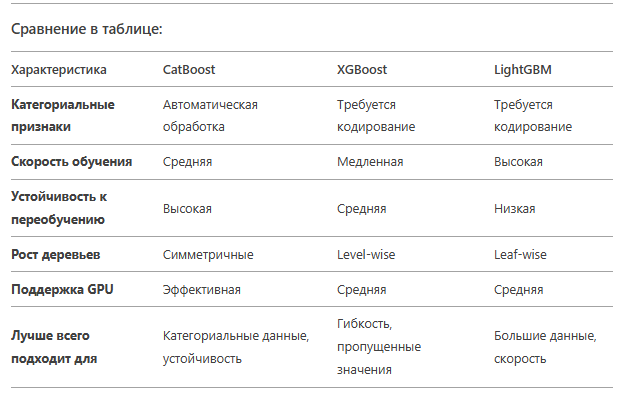

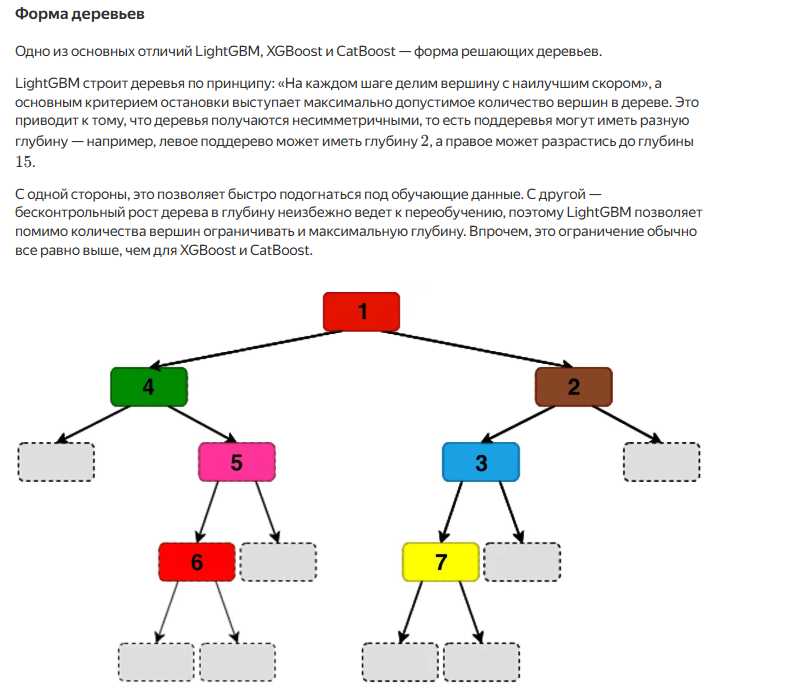

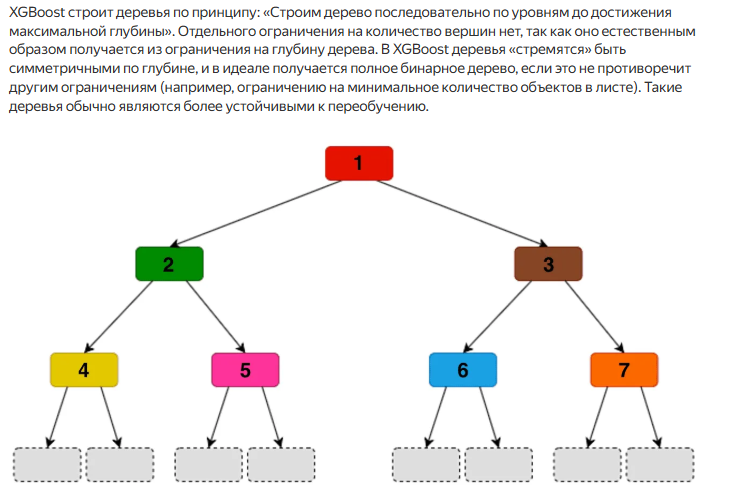

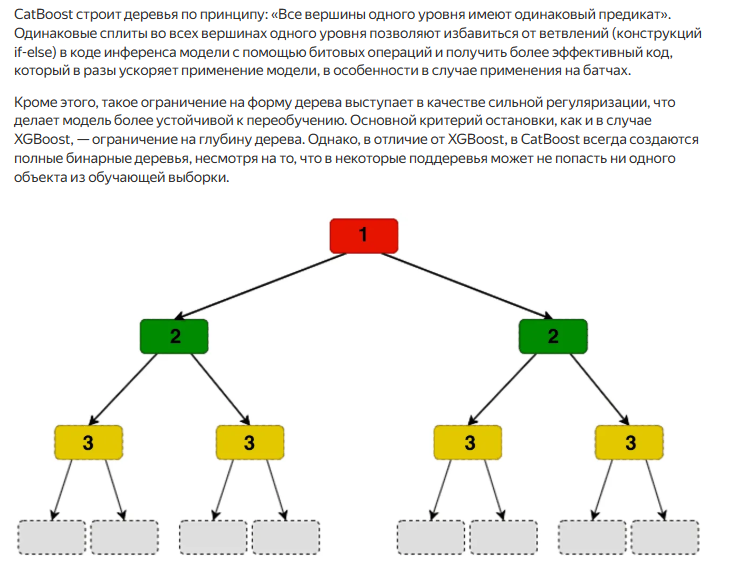

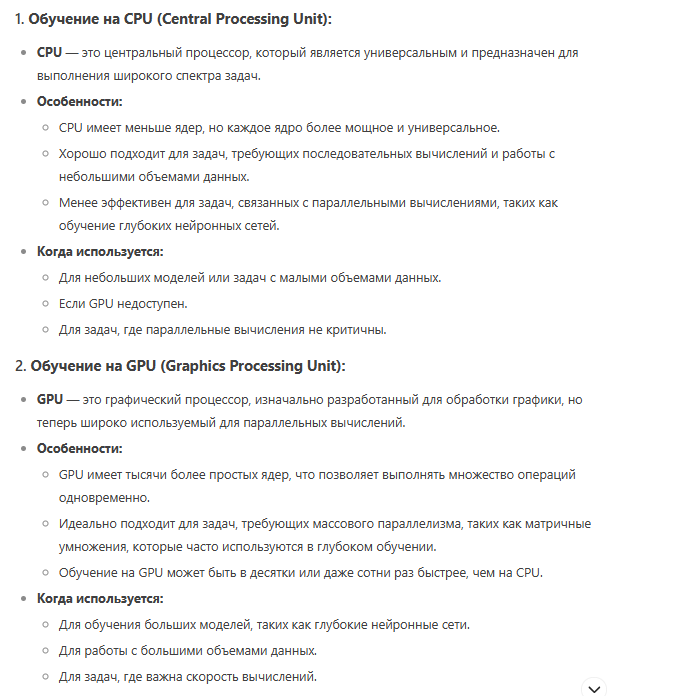